In [1]:
import sys
print(sys.version)
print(sys.executable)
print(sys.path)

3.8.5 (default, Sep  5 2020, 10:50:12) 
[GCC 10.2.0]
/usr/bin/python3
['/home/hboekema/Documents/Jobs/T-DAB/DS 2020 Exercise/notebooks', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/hboekema/.local/lib/python3.8/site-packages', '/usr/lib/python3.8/site-packages', '/usr/lib/python3.8/site-packages/IPython/extensions', '/home/hboekema/.ipython']


In [2]:
import os
import numpy as np
import pandas as pd
import sklearn
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt

# Load data into pandas DataFrame

In [3]:
class DataLoader:
    def __init__(self, datapath=None):
        self._set_working_directory()
        if datapath is None:
            self._set_datapath_if_unspecified()
        else:
            self.datapath = datapath
        
    def _set_working_directory(self):
        current_running_directory = os.getcwd()
        self.project_working_directory = current_running_directory.replace("notebooks", "")

    def _set_datapath_if_unspecified(self):
        default_subdir_path = "data/test_data.csv"
        self.datapath = os.path.join(self.project_working_directory, default_subdir_path)
        
    def load_dataframe_from_datapath(self):
        indices_of_columns_to_parse_as_dates = [24]
        return pd.read_csv(self.datapath, parse_dates=indices_of_columns_to_parse_as_dates)
    

In [4]:
# Load data
dataframe = DataLoader().load_dataframe_from_datapath()
print(dataframe)
print(dataframe.dtypes)

        CurrentSpeed  CurrentDir   TWS   TWA        AWS   AWA       Roll  \
0             0.0756       123.0  10.8  48.0  10.400000  48.0  -3.540000   
1             0.0756       123.0  10.8  48.0  10.400000  48.0  -3.540000   
2             0.0756       123.0  10.8  48.0  10.400000  48.0  -3.520000   
3             0.0756       123.0  10.8  48.0  10.400000  48.0  -3.520000   
4             0.0756       123.0  10.8  48.0  10.400000  48.0  -3.500000   
...              ...         ...   ...   ...        ...   ...        ...   
219995        1.7496       103.0  14.6  56.0  21.100000  33.0 -16.440001   
219996        1.7496       101.0  14.7  58.0  20.500000  37.0 -17.980000   
219997        1.8576       100.0  14.5  60.0  20.299999  37.0 -17.660000   
219998        1.8522       103.0  15.2  57.0  22.100000  35.0 -18.559999   
219999        1.8090       104.0  14.9  57.0  21.400000  33.0 -17.039999   

           Pitch  HeadingMag    HoG  ...     VMG  RudderAng  Leeway    TWD  \
0       9

# Check for missing values

In [19]:
def get_number_of_missing_values_by_column(dataframe):
    return dataframe.isna().sum()

In [20]:
missing_values = get_number_of_missing_values_by_column(dataframe)
print(missing_values)

CurrentSpeed    167
CurrentDir      168
TWS             163
TWA             167
AWS             166
AWA             162
Roll            167
Pitch           164
HeadingMag      165
HoG             162
HeadingTrue     163
AirTemp         160
Longitude       164
Latitude        160
SoG             158
SoS             160
AvgSoS          162
VMG             163
RudderAng       162
Leeway          161
TWD             162
WSoG            164
VoltageDrawn    161
ModePilote      161
DateTime          5
Yaw             166
Tacking           5
dtype: int64


There are some missing values, so drop the rows with msising values and ensure that there are enough data samples for training left.

In [22]:
complete_dataframe = dataframe.dropna()
print(len(complete_dataframe.index))

219680


# Quantify data ranges

These are not all listed in the data description, so the first step is determining these ranges (and standardising if appropriate).

In [7]:
def get_extremal_column_values_of_dataframe(dataframe):
    return dataframe.agg(['min', 'max']).transpose()

In [8]:
dataframe_extremal_values = get_extremal_column_values_of_dataframe(dataframe)
print(dataframe_extremal_values)

                              min                  max
CurrentSpeed               0.0162                5.697
CurrentDir                      0                  359
TWS                           1.7                 29.1
TWA                          -179                  179
AWS                           2.8                   37
AWA                          -177                  169
Roll                        -39.3                10.14
Pitch                       -7.88                17.36
HeadingMag                      0                  359
HoG                             0                  359
HeadingTrue                     0                  359
AirTemp                   21.1072              32.4394
Longitude                -61.8169             -59.2794
Latitude                  11.9712              22.2099
SoG                        0.0054              12.5982
SoS                             0              12.7008
AvgSoS                     0.0702                8.532
VMG       

Some of angular data is in the range [0, 359], some of it in [-179, 179], and Yaw is even in [-359, 359]! All of these will be converted to a standard range e.g. [-179, 179] before being used for prediction.

# Whisker plot of features

Visualise the distribution of the data to get an idea of what predictive techniques to consider for task 2.

<IPython.core.display.Javascript object>


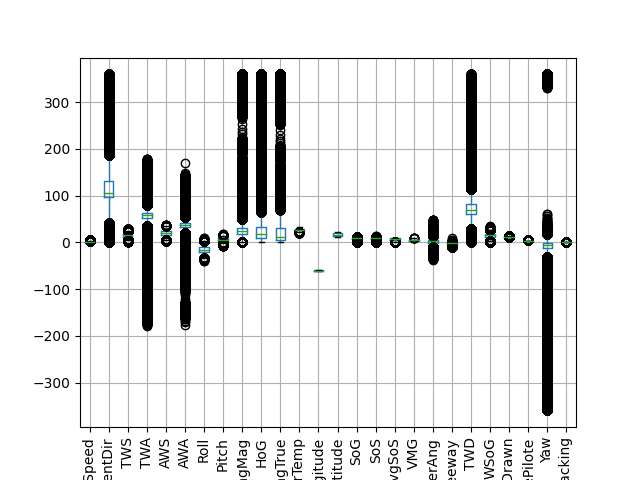

In [9]:
dataframe.boxplot()
plt.xticks(rotation=90)
plt.show()

# Quantify class imbalance

In [10]:
def get_tacking_class_ratio_from_dataframe(dataframe):
    tacking_series = dataframe["Tacking"]
    
    unlabelled_instances_count = tacking_series.isna().sum()
    labelled_instances_count = tacking_series.count()
    total_count = unlabelled_instances_count + labelled_instances_count
    tacking_class_instances = tacking_series.sum()
    not_tacking_class_instances = labelled_instances_count - tacking_class_instances
    
    tacking_ratio = float(tacking_class_instances) / float(labelled_instances_count)
    unlabelled_instances_ratio = float(unlabelled_instances_count) / float(total_count)
    return tacking_ratio, tacking_class_instances, not_tacking_class_instances, unlabelled_instances_ratio

In [11]:
tacking_ratio, tacking_class_instances, not_tacking_class_instances, unlabelled_instances_ratio = get_tacking_class_ratio_from_dataframe(dataframe)
print("Tacking ratio: %.03f" % tacking_ratio)
print("Tacking class instances: %d" % tacking_class_instances)
print("Not tacking class instances: %d" % not_tacking_class_instances)
print("Unlabelled instances ratio: %.05f" % unlabelled_instances_ratio)

Tacking ratio: 0.209
Tacking class instances: 46039
Not tacking class instances: 173956
Unlabelled instances ratio: 0.00002


Classes are unbalanced and some points are unlabelled. Need to remove the unlabelled rows.

# Explore correlation between features and tacking classification

This is a simple litmus test for identifying (linear) relationships between features and the target, and detecting collinear input features. The Pearson correlation is used for this purpose.

In [12]:
class DataFrameLinearCorrelationFinder:
    def __init__(self, dataframe):
        self.dataframe = dataframe
    
    def get_feature_corr_with_tacking(self, *args, **kwargs):
        tacking_series = self.dataframe["Tacking"]
        feature_dataframe = self.dataframe.drop(columns="Tacking", inplace=False)

        feature_corr_with_tacking = feature_dataframe.corrwith(tacking_series, *args, **kwargs)
        return feature_corr_with_tacking

    def get_feature_collinearity(self, *args, **kwargs):
        feature_dataframe = self.dataframe.drop(columns="Tacking")
        
        feature_collinearity = feature_dataframe.corr()
        return feature_collinearity
    
    def get_collinear_feature_pairs(self, threshold, *args, **kwargs):
        feature_collinearity = self.get_feature_collinearity()
        
        # Stack the features to allow pairs of features to be filtered by their correlation score
        stacked_feature_correlations = feature_collinearity.stack()
        features_with_large_correlation = abs(stacked_feature_correlations) > threshold
        collinear_feature_pairs_with_duplicates = stacked_feature_correlations[features_with_large_correlation]
        
        collinear_feature_pairs = collinear_feature_pairs_with_duplicates.drop_duplicates()
        print(collinear_feature_pairs)

In [13]:
linear_corr_finder = DataFrameLinearCorrelationFinder(dataframe)

In [14]:
feature_corr_with_tacking = linear_corr_finder.get_feature_corr_with_tacking()
print(feature_corr_with_tacking)

CurrentSpeed   -0.396365
CurrentDir      0.431117
TWS            -0.311944
TWA             0.110141
AWS            -0.563277
AWA             0.371277
Roll            0.596005
Pitch           0.365490
HeadingMag      0.132467
HoG             0.503146
HeadingTrue     0.040227
AirTemp         0.472660
Longitude      -0.407314
Latitude       -0.452816
SoG            -0.722064
SoS            -0.720361
AvgSoS         -0.763796
VMG            -0.626334
RudderAng       0.169972
Leeway          0.493317
TWD             0.452589
WSoG           -0.269085
VoltageDrawn   -0.162096
ModePilote      0.717051
Yaw            -0.378158
dtype: float64


In [15]:
feature_collinearity = linear_corr_finder.get_feature_collinearity()
print(feature_collinearity)

              CurrentSpeed  CurrentDir       TWS       TWA       AWS  \
CurrentSpeed      1.000000   -0.302749  0.254630 -0.181874  0.283108   
CurrentDir       -0.302749    1.000000 -0.270229 -0.080097 -0.366651   
TWS               0.254630   -0.270229  1.000000 -0.023997  0.907994   
TWA              -0.181874   -0.080097 -0.023997  1.000000 -0.077054   
AWS               0.283108   -0.366651  0.907994 -0.077054  1.000000   
AWA              -0.344489    0.062720 -0.052633  0.856178 -0.226423   
Roll             -0.321025    0.378580 -0.759107  0.003270 -0.884839   
Pitch            -0.178857    0.249048 -0.491641 -0.003676 -0.527444   
HeadingMag       -0.003126    0.042042 -0.199612  0.003189 -0.277245   
HoG              -0.218598    0.242099 -0.311549  0.110552 -0.427116   
HeadingTrue       0.022561   -0.193882 -0.003153  0.043675 -0.007691   
AirTemp          -0.444777    0.464708 -0.201477 -0.013605 -0.377424   
Longitude         0.619248   -0.474400  0.024899  0.082594  0.15

In [16]:
collinear_feature_pairs = linear_corr_finder.get_collinear_feature_pairs(threshold=0.7)
print(collinear_feature_pairs)

CurrentSpeed  CurrentSpeed    1.000000
TWS           AWS             0.907994
              Roll           -0.759107
              WSoG            0.857520
TWA           AWA             0.856178
AWS           Roll           -0.884839
              SoG             0.749820
              SoS             0.751400
              WSoG            0.795332
Roll          SoG            -0.800788
              SoS            -0.801109
Longitude     Latitude        0.996562
              AvgSoS          0.737277
Latitude      AvgSoS          0.785522
SoG           SoS             0.999162
              AvgSoS          0.806154
              VMG             0.783535
              ModePilote     -0.882801
SoS           AvgSoS          0.804244
              VMG             0.789141
              ModePilote     -0.880642
AvgSoS        ModePilote     -0.786978
VMG           ModePilote     -0.709826
dtype: float64
None


# Feature selection

**Features not to include:**  
  
AirTemp (common sense - irrelevant for tacking)  
VoltageDrawn (common sense - irrelevant for tacking)  
Yaw (linear relationship with HoG and TrueHeading)  
SoS (linear relationship with VMG; strong linear correlation with SoG)  
HeadingMag (chose HeadingTrue)  
ModePilote (check what this is)  
AvgSoS (assumed less important than current SoS/SoG as averaging provides the same information)  
TWD (same information as TWA)  
WSoG (strong linear correlation with TWS; less commonly used by sailors)  
Longitude (assumed irrelevant)  
Latitude (assumed irrelevant)  

**Features to include:**  
  
CurrentSpeed  
CurrentDir
TWS  
TWA  
AWS  
AWA  
Roll  
Pitch  
HoG  
HeadingTrue  
SoG  
VMG  
RudderAng  
Leeway  
ModePilote (?)

# Explore autocorrelation of features